# Resumo do projeto:

A SyncHeart é uma empresa focada no monitoramento de Marca-passos.
Abaixo segue gráficos e correlações do qual foram formados para trazer uma métrica a respeito dos gráficos e alertas dentro do nosso Sistema.

# Instalando bibliotecas e fazendo tratamento dos dados.

In [2]:
# -------------------------
# Instalação
# -------------------------
 install.packages(c('tidyverse', 'readr', 'lubridate', 'GGally', 'corrplot', 'pROC', 'effects', 'reshape2'))

# -------------------------
# Bibliotecas
# -------------------------
library(tidyverse)   # inclui ggplot2, dplyr, tidyr, etc.
library(readr)
library(lubridate)
library(GGally)
library(corrplot)
library(pROC)
library(effects)
library(reshape2)

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘patchwork’, ‘ggstats’




In [5]:
dados <- read.csv("/content/dados.csv", header = TRUE, sep = ",", stringsAsFactors = FALSE)
dados2 <- read.csv("/content/dados2.csv", header = TRUE, sep = ",", stringsAsFactors = FALSE)


# -------------------------
#         limpeza
# -------------------------

# Converte tipos
# Arritmia: True == 1 e False == 0
dados$arritmia_detectada[dados$arritmia_detectada == 'True'] <- '1'
dados$arritmia_detectada[dados$arritmia_detectada == 'False'] <- '0'

dados$arritmia_detectada <- as.numeric(dados$arritmia_detectada)


dados2$arritmia_detectada[dados2$arritmia_detectada == 'True'] <- '1'
dados2$arritmia_detectada[dados2$arritmia_detectada == 'False'] <- '0'

dados2$arritmia_detectada <- as.numeric(dados2$arritmia_detectada)


# Data/hora
if('timestamp_utc' %in% names(dados)){
  dados <- dados %>%
    mutate(horario = ymd_hms(timestamp_utc, tz = 'UTC'))
} else if('horario' %in% names(dados)){
  dados <- dados %>% mutate(horario = ymd_hms(horario, tz = 'UTC'))
} else stop('Coluna timestamp_utc / horario não encontrada no CSV')


numeric_cols <- c('cpu_porcentagem','ram_porcentagem','disco_uso_kb','bateria_porcentagem','total_tarefas_ativas')
for(col in numeric_cols){
  if(col %in% names(dados)) dados[[col]] <- as.numeric(dados[[col]])
}

if('timestamp_utc' %in% names(dados2)){
  dados2 <- dados2 %>%
    mutate(horario = ymd_hms(timestamp_utc, tz = 'UTC'))
} else if('horario' %in% names(dados2)){
  dados2 <- dados2 %>% mutate(horario = ymd_hms(horario, tz = 'UTC'))
} else stop('Coluna timestamp_utc / horario não encontrada no CSV')


numeric_cols2 <- c('cpu_porcentagem','ram_porcentagem','disco_uso_kb','bateria_porcentagem','total_tarefas_ativas')
for(col in numeric_cols2){
  if(col %in% names(dados2)) dados2[[col]] <- as.numeric(dados2[[col]])
}

# Fazendo relatórios sobre os dados capturados.

 função que calcula o tempo gasto

In [38]:
calcular_tempo_acima_limite <- function(valores, limite) {
  sum(valores > limite, na.rm = TRUE) / length(na.omit(valores)) * 100
}

função de criação de relatório

In [49]:


gerar_relatorio <- function(dados){
  cat('=== RELATÓRIO DE MONITORAMENTO ===\n\n')
  cat('Período analisado:', format(min(dados$horario), '%Y-%m-%d %H:%M', tz='UTC'), 'a', format(max(dados$horario), '%Y-%m-%d %H:%M', tz='UTC'), '\n\n')

  cat('ESTATÍSTICAS GERAIS:\n')
  cat('CPU - Média:', round(mean(dados$cpu_porcentagem, na.rm = TRUE), 1), '% | Desvio Padrão:', round(sd(dados$cpu_porcentagem, na.rm = TRUE), 1), '\n')
  cat('RAM - Média:', round(mean(dados$ram_porcentagem, na.rm = TRUE), 1), '% | Desvio Padrão:', round(sd(dados$ram_porcentagem, na.rm = TRUE), 1), '\n')
  cat('Disco - Média (kB):', round(mean(dados$disco_uso_kb, na.rm = TRUE), 1), 'kB\n\n')

  cat('TEMPO ACIMA DE LIMITES CRÍTICOS (porcentagem do tempo):\n')
  cat('CPU > 15%:', round(calcular_tempo_acima_limite(dados$cpu_porcentagem, 15), 1), '%\n')
  cat('RAM > 80%:', round(calcular_tempo_acima_limite(dados$ram_porcentagem, 80), 1), '%\n')
}

# Análise dos dados a partir de matriz de correlação.

                     cpu_porcentagem ram_porcentagem disco_uso_kb
cpu_porcentagem           1.00000000      0.93813643 -0.017245087
ram_porcentagem           0.93813643      1.00000000  0.178290394
disco_uso_kb             -0.01724509      0.17829039  1.000000000
bateria_porcentagem      -0.08486038      0.09343877  0.764281998
total_tarefas_ativas      0.78845323      0.80355669  0.001471346
arritmia_detectada        0.67114279      0.79846630  0.025804142
                     bateria_porcentagem total_tarefas_ativas
cpu_porcentagem              -0.08486038          0.788453226
ram_porcentagem               0.09343877          0.803556691
disco_uso_kb                  0.76428200          0.001471346
bateria_porcentagem           1.00000000         -0.026447963
total_tarefas_ativas         -0.02644796          1.000000000
arritmia_detectada            0.04493728          0.617504653
                     arritmia_detectada
cpu_porcentagem              0.67114279
ram_porcentagem         

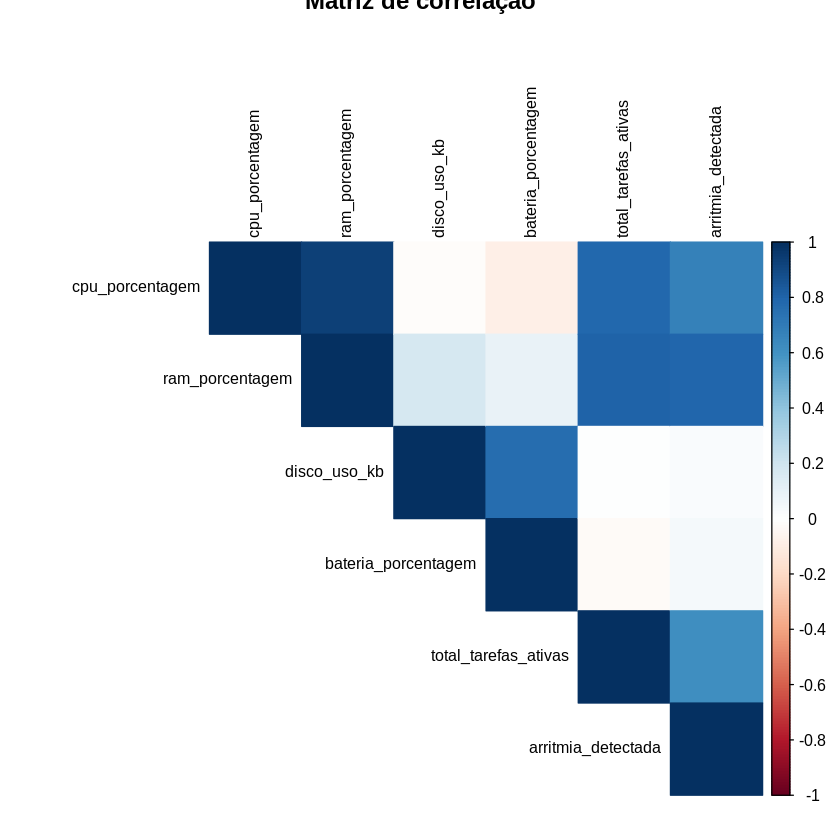

In [9]:
# Matriz de correlação
num_dados <- dados %>% select(any_of(numeric_cols), arritmia_detectada)
corr_matrix <- cor(num_dados, use = 'complete.obs')
print(corr_matrix)

# Plota correlograma
corrplot(corr_matrix, method = 'color', type = 'upper', tl.col = 'black', tl.cex = 0.8,
         main = 'Matriz de correlação')

#Histogramas das variáveis principais

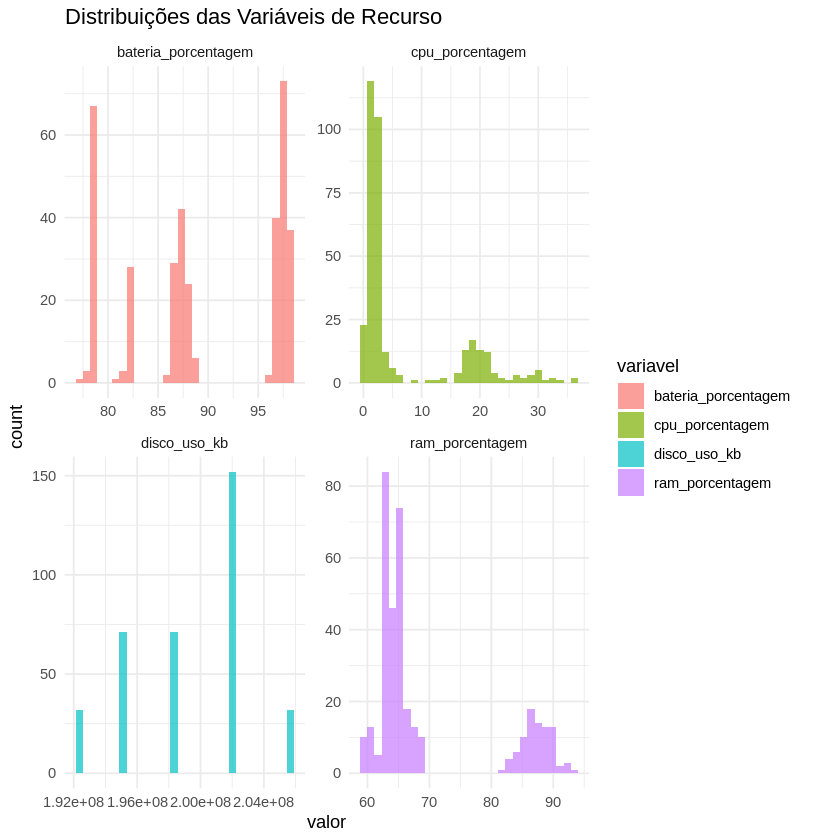

In [11]:
dados %>%
  pivot_longer(cols = any_of(c('cpu_porcentagem','ram_porcentagem','disco_uso_kb','bateria_porcentagem')),
               names_to = 'variavel', values_to = 'valor') %>%
  ggplot(aes(x = valor, fill = variavel)) +
  geom_histogram(bins = 30, alpha = 0.7) +
  facet_wrap(~variavel, scales = 'free') +
  theme_minimal() +
  labs(title = 'Distribuições das Variáveis de Recurso')

# Escala de cpu x ram sinalizado por arritmia


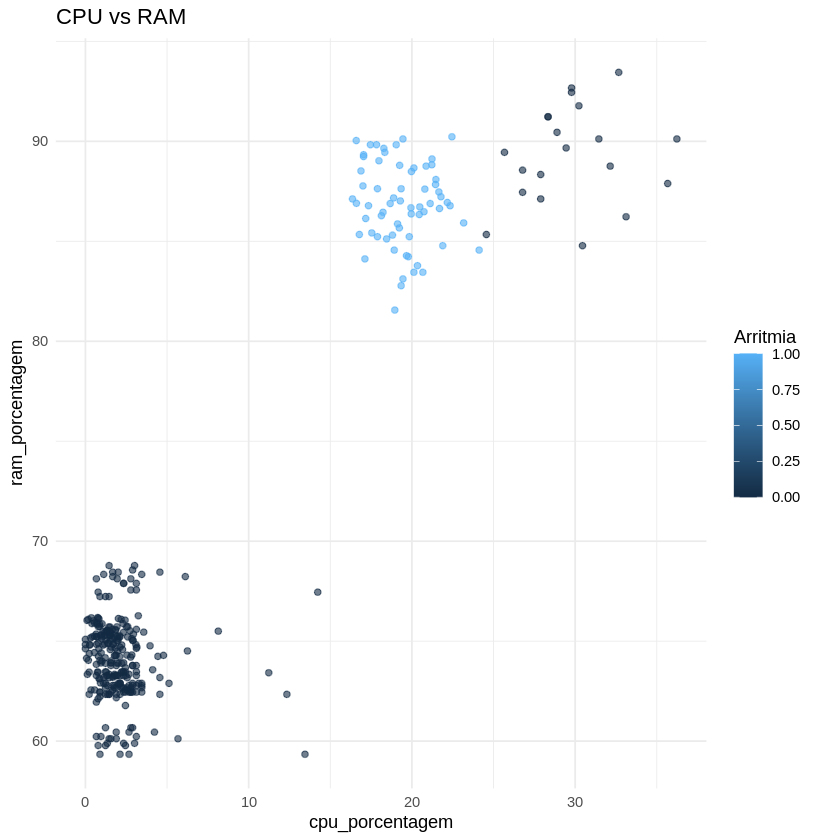

In [15]:
p1 <- ggplot(dados, aes(x = cpu_porcentagem, y = ram_porcentagem, color = arritmia_detectada)) +
  geom_point(alpha = 0.6) +
  theme_minimal() +
  labs(title = 'CPU vs RAM', color = 'Arritmia')
print(p1)

# CPU ao longo do tempo e RAM ao longo do tempo (linhas juntas)

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


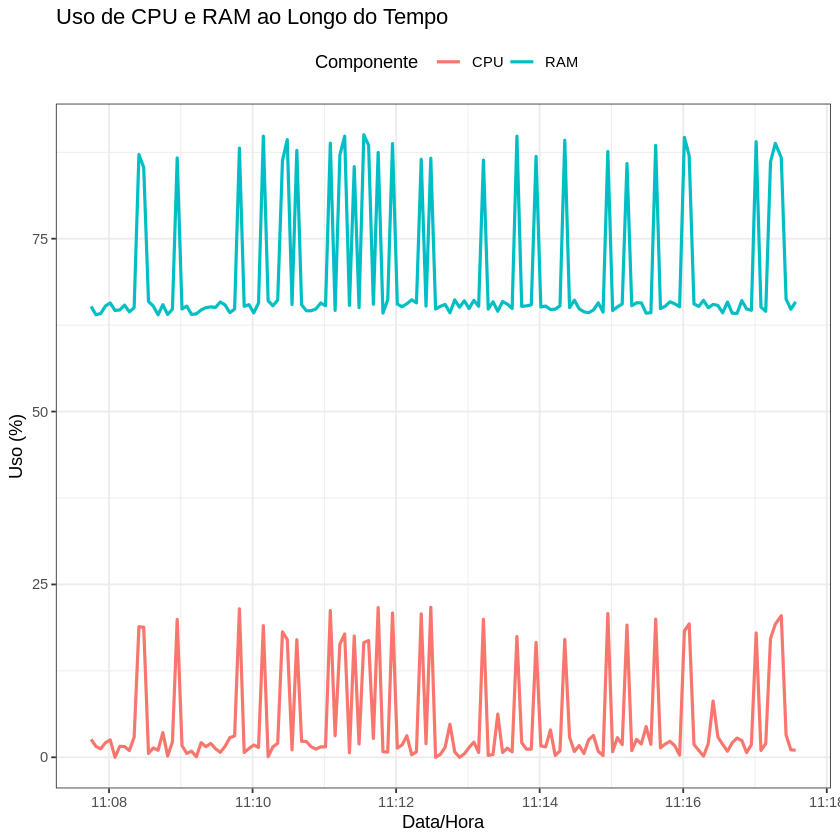

In [17]:
p_time <- ggplot(dados2, aes(x = horario)) +
  geom_line(aes(y = cpu_porcentagem, color = 'CPU'), size = 0.9) +
  geom_line(aes(y = ram_porcentagem, color = 'RAM'), size = 0.9) +
  labs(title = 'Uso de CPU e RAM ao Longo do Tempo', x = 'Data/Hora', y = 'Uso (%)', color = 'Componente') +
  theme_bw() +
  theme(legend.position = 'top')
print(p_time)

# Matriz de gráficos de densidade, plot e correlações das variáveis selecionadas.

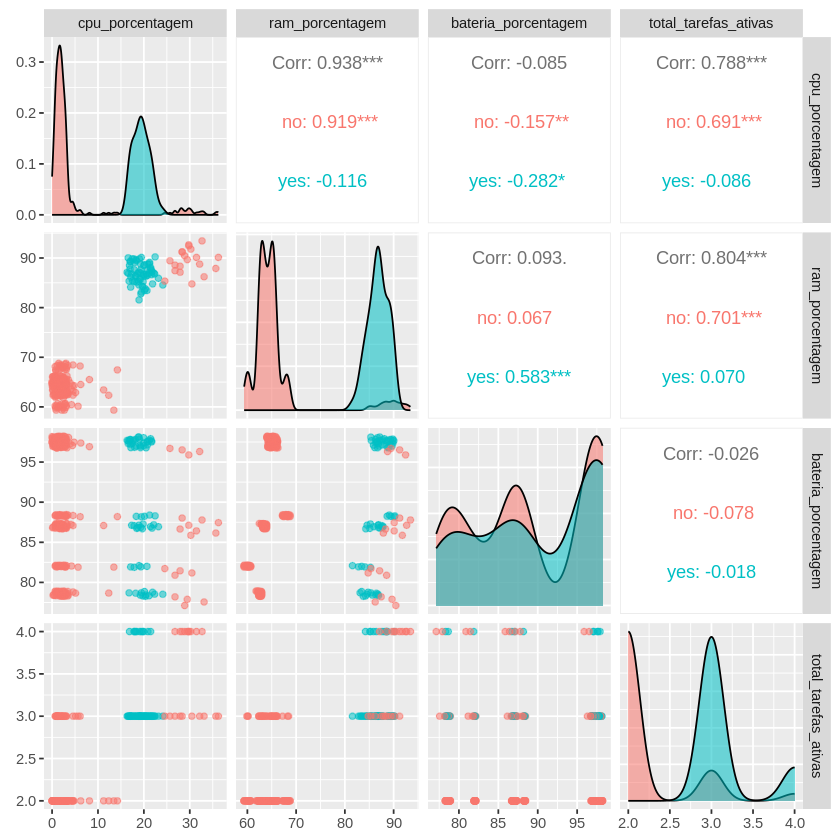

In [20]:
if(all(c('cpu_porcentagem','ram_porcentagem','bateria_porcentagem','total_tarefas_ativas',
         'arritmia_detectada') %in% names(dados))){


  ggpairs(dados %>% select(cpu_porcentagem, ram_porcentagem, bateria_porcentagem, total_tarefas_ativas, arritmia_fac),
          columns = 1:4,
          mapping = ggplot2::aes(color = arritmia_fac, alpha = 0.6))


}

# plots de densidade por arrtimia para cada variável

Warning message:
“`aes_string()` was deprecated in ggplot2 3.0.0.
ℹ Please use tidy evaluation idioms with `aes()`.
ℹ See also `vignette("ggplot2-in-packages")` for more information.”


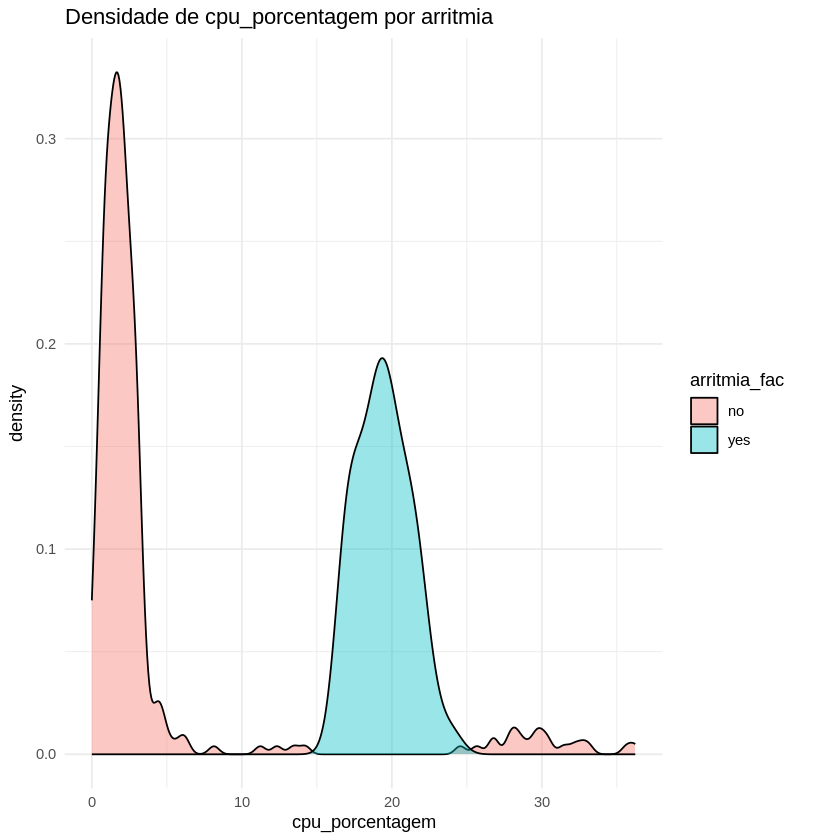

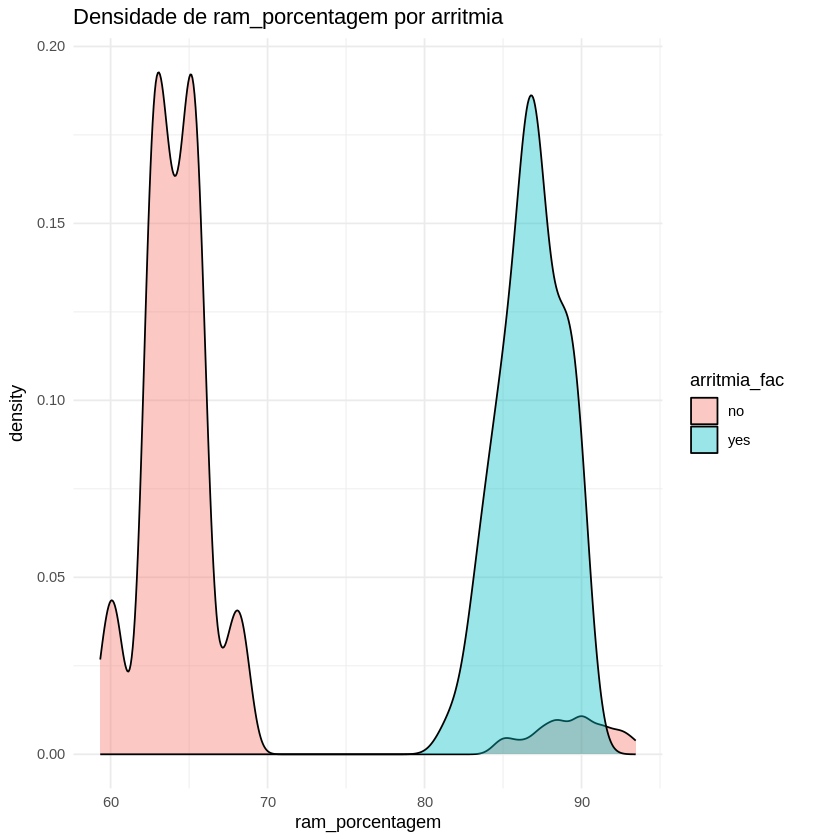

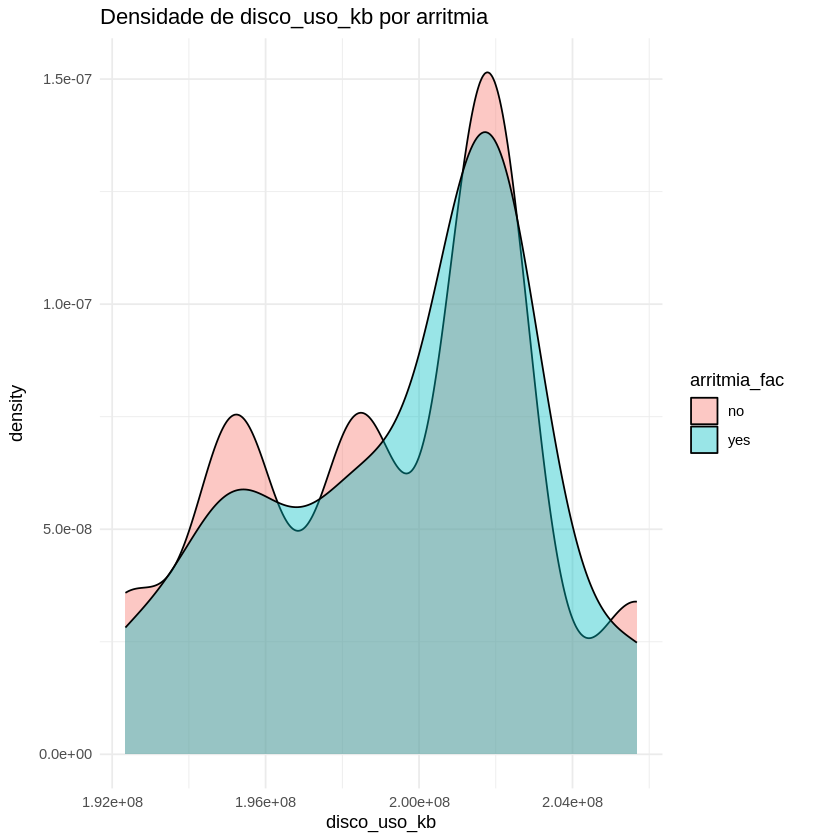

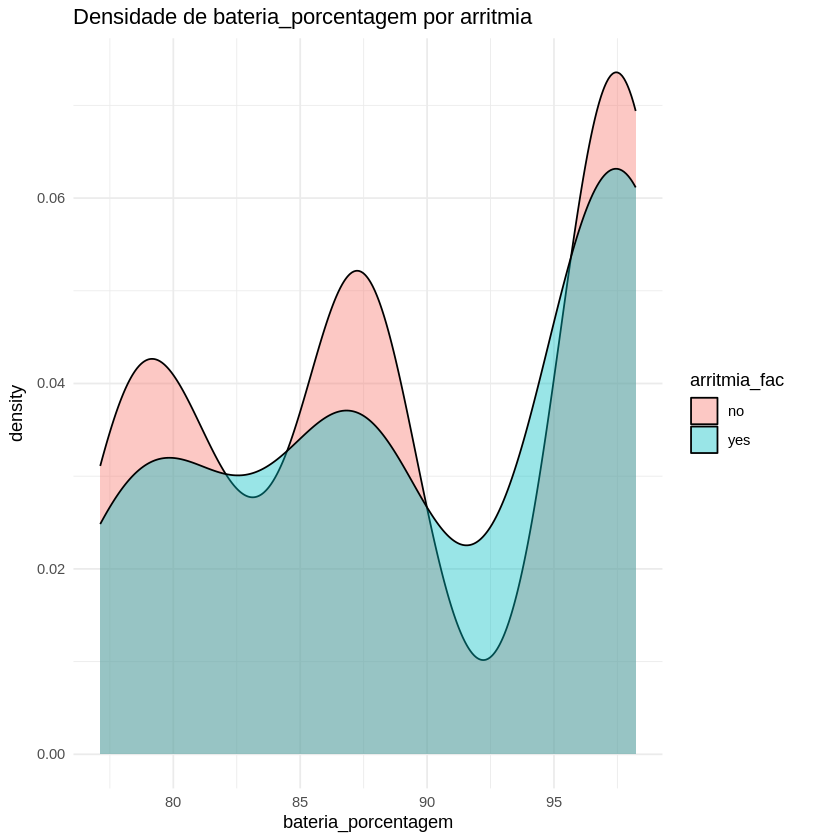

In [21]:
vars <- intersect(c('cpu_porcentagem','ram_porcentagem','disco_uso_kb','bateria_porcentagem'), names(dados))
for(v in vars){

  p2 <- ggplot(dados %>% filter(!is.na(.data[[v]])), aes_string(x = v, fill = "arritmia_fac")) +
    geom_density(alpha = 0.4) +
    labs(title = paste("Densidade de", v, "por arritmia"), x = v) +
    theme_minimal()
  print(p2)
}

# mapa de correlação entre variáveis de leitura

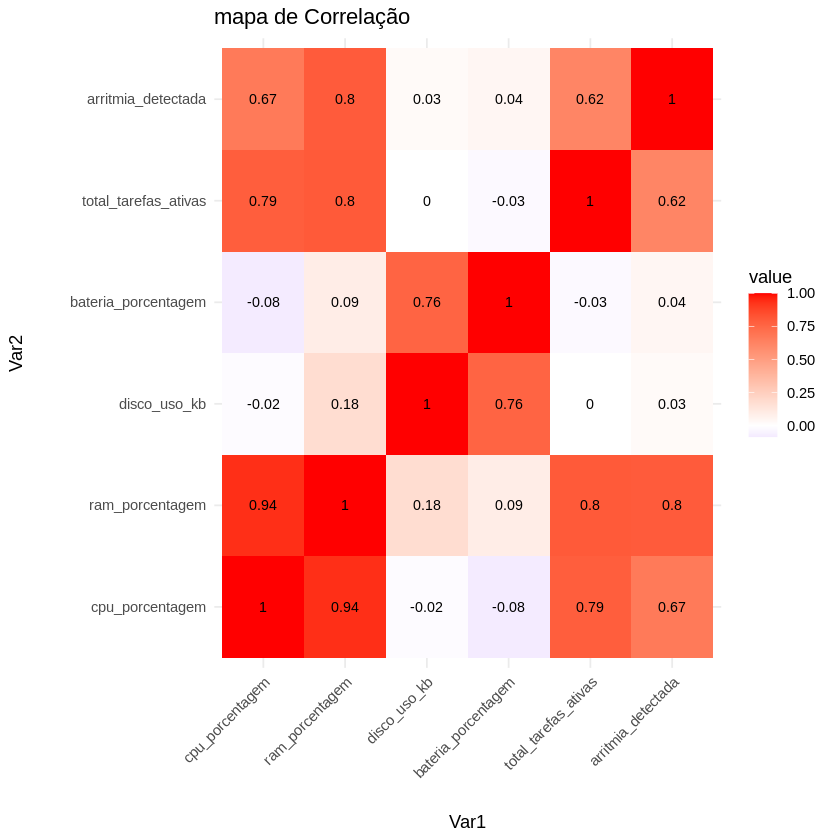

In [26]:
if(ncol(corr_matrix) > 1){
  cm <- reshape2::melt(corr_matrix)
  ggplot(cm, aes(Var1, Var2, fill = value)) +
    geom_tile() +
    geom_text(aes(label = round(value,2)), size = 3) +
    scale_fill_gradient2(low = "blue", mid = "white", high = "red", midpoint = 0) +
    labs(title = "mapa de Correlação") +
    theme_minimal() + theme(axis.text.x = element_text(angle = 45, hjust = 1))
}

# Modelo base com 3 preditores

In [27]:
modelo <- glm(arritmia_detectada ~ cpu_porcentagem + ram_porcentagem + total_tarefas_ativas,
              data = dados, family = binomial)
cat('--- Sumário do modelo ---\n')
print(summary(modelo))

--- Sumário do modelo ---

Call:
glm(formula = arritmia_detectada ~ cpu_porcentagem + ram_porcentagem + 
    total_tarefas_ativas, family = binomial, data = dados)

Coefficients:
                     Estimate Std. Error z value Pr(>|z|)    
(Intercept)          -87.6031    16.6300  -5.268 1.38e-07 ***
cpu_porcentagem       -0.9287     0.2088  -4.448 8.65e-06 ***
ram_porcentagem        1.3274     0.2597   5.111 3.20e-07 ***
total_tarefas_ativas  -1.6387     1.0658  -1.538    0.124    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 339.210  on 357  degrees of freedom
Residual deviance:  55.107  on 354  degrees of freedom
AIC: 63.107

Number of Fisher Scoring iterations: 9



# Previsões e avaliação simples

In [31]:
dado_prev <- dados %>% mutate(pred_prob = predict(modelo, type = 'response'),
                          pred_classe = if_else(pred_prob > 0.5, 1, 0))

conf_mat <- table(Predito = dado_prev$pred_classe, Real = dado_prev$arritmia_detectada)
cat('Matriz de confusão (threshold 0.5):\n')
print(conf_mat)

modelo_cpu <- glm(arritmia_detectada ~ cpu_porcentagem, data = dado_prev, family = binomial)
print(summary(modelo_cpu))

print("---------------------------------------------------")

modelo <- glm(arritmia_detectada ~ cpu_porcentagem,
              data = dado_prev, family = binomial)
print(summary(modelo))

print("---------------------------------------------------")

modelo2 <- glm(arritmia_detectada ~ ram_porcentagem,
              data = dado_prev, family = binomial)
print(summary(modelo2))


Matriz de confusão (threshold 0.5):
       Real
Predito   0   1
      0 273  22
      1  20  43

Call:
glm(formula = arritmia_detectada ~ cpu_porcentagem, family = binomial, 
    data = dado_prev)

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -3.54132    0.33232  -10.66   <2e-16 ***
cpu_porcentagem  0.19135    0.02029    9.43   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 339.21  on 357  degrees of freedom
Residual deviance: 197.23  on 356  degrees of freedom
AIC: 201.23

Number of Fisher Scoring iterations: 6

[1] "---------------------------------------------------"

Call:
glm(formula = arritmia_detectada ~ cpu_porcentagem, family = binomial, 
    data = dado_prev)

Coefficients:
                Estimate Std. Error z value Pr(>|z|)    
(Intercept)     -3.54132    0.33232  -10.66   <2e-16 ***
cpu_porcentagem  0.19135    0.02029    9.4

# Gráfico da relação logística (CPU)

`geom_smooth()` using formula = 'y ~ x'


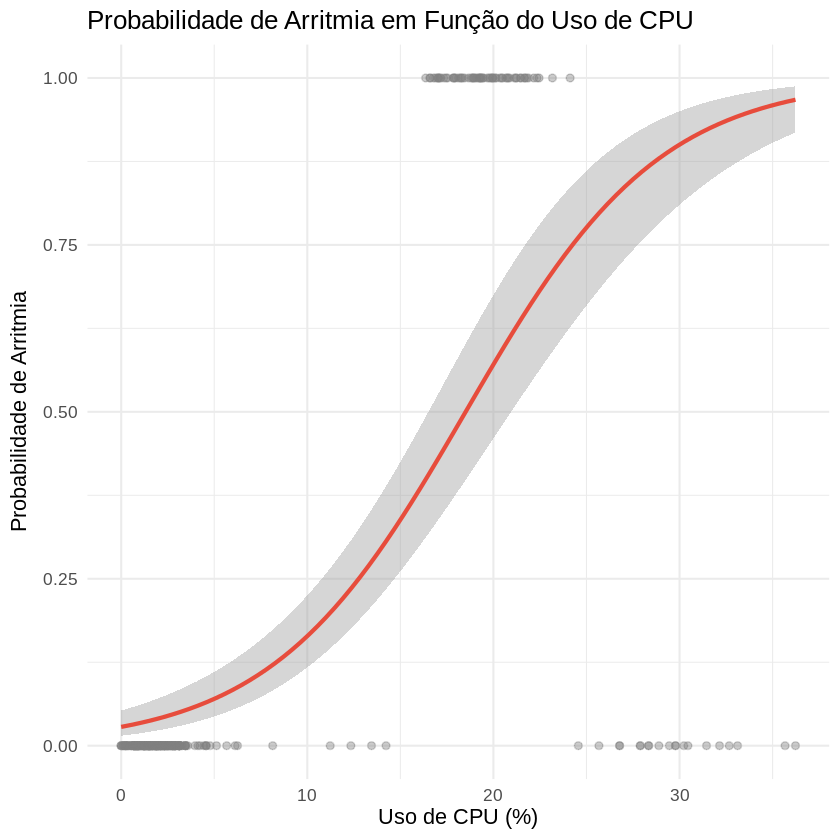

In [32]:
p_log <- ggplot(dados, aes(x = cpu_porcentagem, y = arritmia_detectada)) +
  geom_point(alpha = 0.4, color = "gray50") +
  stat_smooth(method = "glm", method.args = list(family = "binomial"),
              se = TRUE, color = "#E74C3C", linewidth = 1.2) +
  labs(
    title = "Probabilidade de Arritmia em Função do Uso de CPU",
    x = "Uso de CPU (%)",
    y = "Probabilidade de Arritmia"
  ) +
  theme_minimal(base_size = 13)

p_log

# Gráfico da relação logística (RAM)

`geom_smooth()` using formula = 'y ~ x'


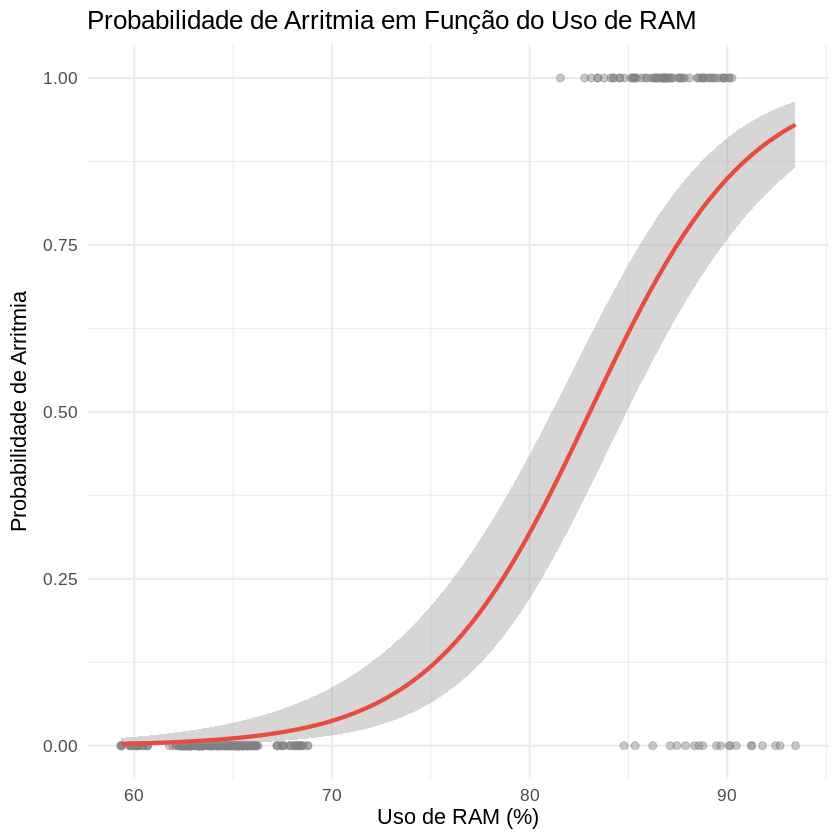

In [33]:
p_log2 <- ggplot(dados, aes(x = ram_porcentagem, y = arritmia_detectada)) +
  geom_point(alpha = 0.4, color = "gray50") +
  stat_smooth(method = "glm", method.args = list(family = "binomial"),
              se = TRUE, color = "#E74C3C", linewidth = 1.2) +
  labs(
    title = "Probabilidade de Arritmia em Função do Uso de RAM",
    x = "Uso de RAM (%)",
    y = "Probabilidade de Arritmia"
  ) +
  theme_minimal(base_size = 13)

p_log2

# Gráfico da relação logística (Processos)

`geom_smooth()` using formula = 'y ~ x'


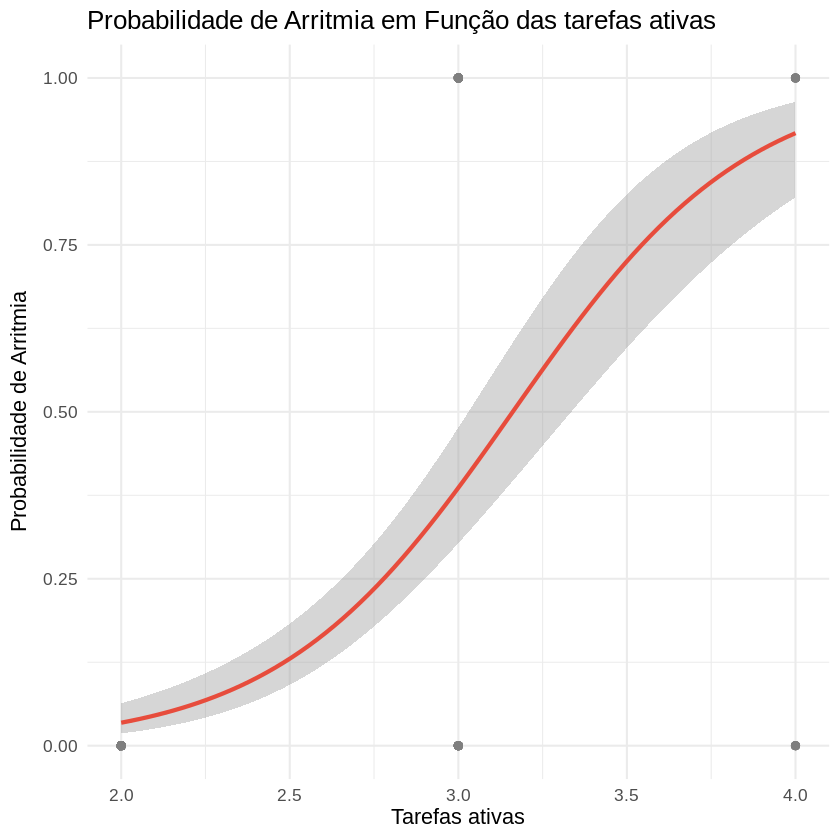

In [35]:
p_log3 <- ggplot(dados, aes(x = total_tarefas_ativas, y = arritmia_detectada)) +
  geom_point(alpha = 0.6, color = "gray50") +
  stat_smooth(method = "glm", method.args = list(family = "binomial"),
              se = TRUE, color = "#E74C3C", linewidth = 1.2) +
  labs(
    title = "Probabilidade de Arritmia em Função das tarefas ativas",
    x = "Tarefas ativas",
    y = "Probabilidade de Arritmia"
  ) +
  theme_minimal(base_size = 13)

p_log3

# Relatório final

In [50]:
gerar_relatorio(dados)

=== RELATÓRIO DE MONITORAMENTO ===

Período analisado: 2025-10-10 11:07 a 2025-12-18 08:21 

ESTATÍSTICAS GERAIS:
CPU - Média: 6.8 % | Desvio Padrão: 8.9 
RAM - Média: 69.6 % | Desvio Padrão: 10.2 
Disco - Média (kB): 199335155 kB

TEMPO ACIMA DE LIMITES CRÍTICOS (porcentagem do tempo):
CPU > 15%: 23.7 %
RAM > 80%: 23.7 %


In [51]:
gerar_relatorio(dados2)

=== RELATÓRIO DE MONITORAMENTO ===

Período analisado: 2025-10-10 11:07 a 2025-10-10 11:17 

ESTATÍSTICAS GERAIS:
CPU - Média: 5.3 % | Desvio Padrão: 7.2 
RAM - Média: 69.9 % | Desvio Padrão: 9.3 
Disco - Média (kB): 201797105 kB

TEMPO ACIMA DE LIMITES CRÍTICOS (porcentagem do tempo):
CPU > 15%: 20.9 %
RAM > 80%: 20.9 %


# Conclusão:

A partir dessas análises, é possível retirar as métricas para os alertas. Um exemplo que pode ser visto é o gráfico de relação logística de CPU, que demonstra que um alerta de arritmia pode ser ativado assim que a CPU passar de 15% (momento em que começa a subir), dentre outros.